In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import numpy as np

In [2]:
# Load chessboard image
img_file = 'camera_cal/calibration2.jpg'
img = cv2.imread(img_file)

(720, 1280, 3)


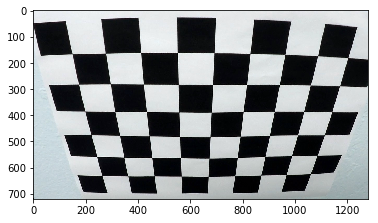

In [3]:
print(img.shape)
plt.imshow(img)

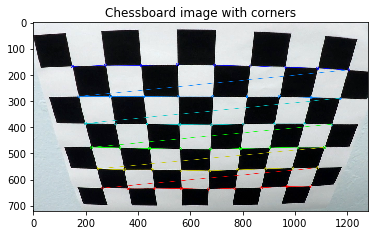

In [4]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

In [5]:
objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

cal_images = glob.glob("camera_cal/calibration*.jpg")

for cal_image in cal_images:
    img = cv2.imread(cal_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# calibration, get camera matrix and distortion coefficients
ret, cmtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)

(-0.5, 1279.5, 719.5, -0.5)

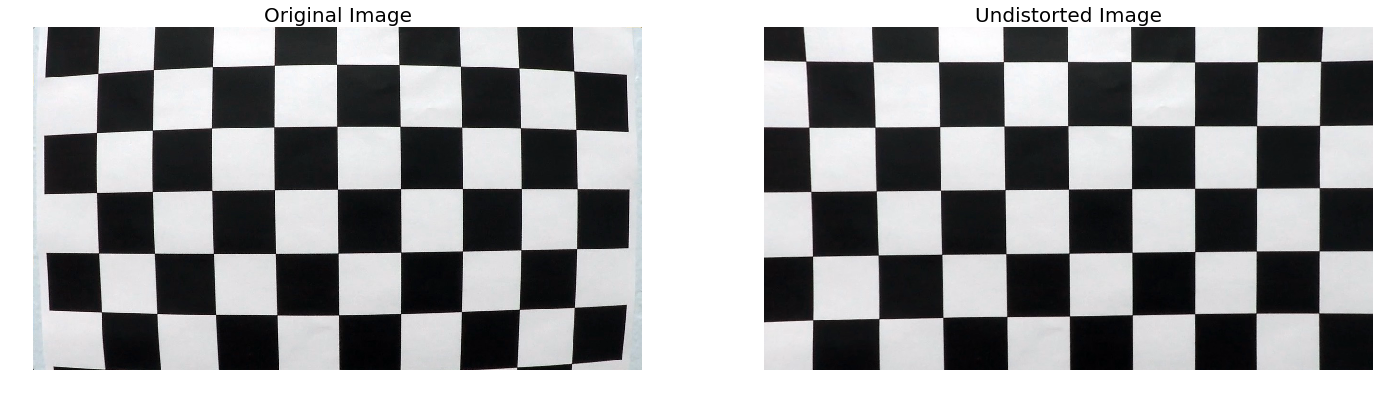

In [6]:
img_file = 'camera_cal/calibration1.jpg'
img = cv2.imread(img_file)
undist = cv2.undistort(img, cmtx, dist_coeffs, None, cmtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
ax1.axis('off')
ax2.axis('off')

In [7]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # gradient along x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    direction = np.absolute(direction)
    
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return binary mask
    return mask

def threshold_image(img):
    
    img = cv2.undistort(img, cmtx, dist_coeffs, None, cmtx)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    combined = np.zeros_like(gray)
    
    height, width = gray.shape

    sx_binary = abs_sobel_thresh(gray, 'x', thresh_min=10, thresh_max=200)
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]

    # S channel thresholds, for detecting white and yellow
    s_thresh = (100, 255)
    s_binary = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # L channel thresholds, avoid dark regions
    l_thresh = (100, 255)
    l_binary = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds

    combined[(l_binary) & (s_binary | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combined, mask)
    
    return thresholded

(-0.5, 1279.5, 719.5, -0.5)

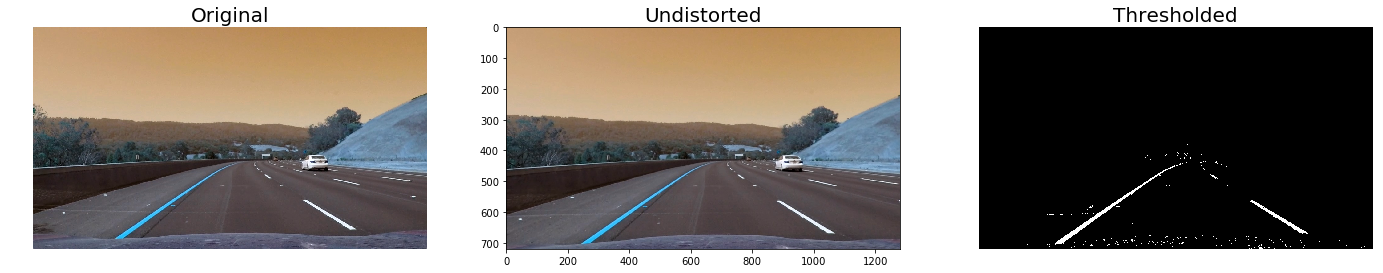

In [8]:
#plt.switch_backend('Qt5Agg')
img = cv2.imread('test_images/test3.jpg')
thresholded = threshold_image(img)
undist_img = cv2.undistort(img, cmtx, dist_coeffs, None, cmtx)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Undistorted', fontsize=20)
ax3.imshow(thresholded, cmap='gray')
ax3.set_title('Thresholded', fontsize=20)
ax1.axis('off')
#ax2.axis('off')
ax3.axis('off')


### Perspective Transform

In [9]:
img = cv2.imread('test_images/test3.jpg')
undist_img = cv2.undistort(img, cmtx, dist_coeffs, None, cmtx)
thresholded = threshold_image(img)

In [10]:
tl = [580, 450] # [550, 480] #[595, 450]
tr = [690, 450] # [740, 480] #[680,450]
br = [1120, 720]
bl = [190, 720]
src = np.float32([tl,tr,br,bl])
dbl = [250,720]
dbr = [1000, 720]
dtl = [250, 0]
dtr = [1000, 0]
dst = np.float32([dtl, dtr, dbr, dbl])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

binary_warped = warp(thresholded)

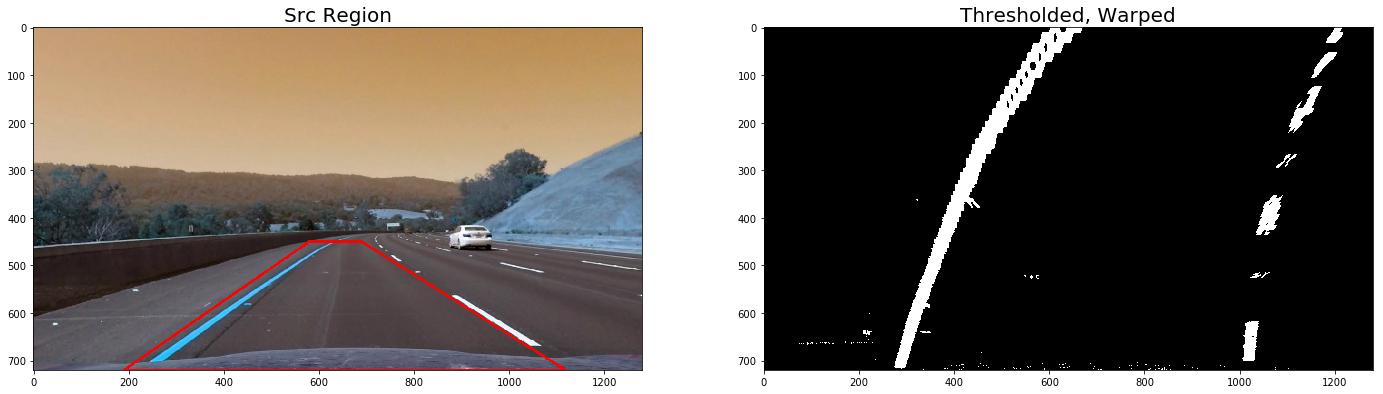

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
copy = undist_img.copy()
pts = np.array([tl,tr,br,bl], np.int32)
pts = pts.reshape((-1,1,2))
dpts = np.array([dtl,dtr,dbr,dbl], np.int32)
dpts = dpts.reshape((-1,1,2))
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)
ax1.imshow(copy)
ax1.set_title('Src Region', fontsize=20)
#cv2.polylines(warped,[dpts],True,(255,0,0), thickness=3)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Thresholded, Warped', fontsize=20)

### Histogram

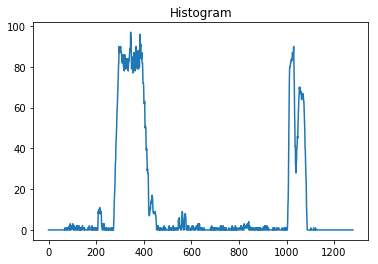

In [12]:
def get_hist_and_xbase(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print(leftx_base, rightx_base)
    return histogram, leftx_base, rightx_base
    
histogram, leftx_base, rightx_base = get_hist_and_xbase(binary_warped)    
plt.plot(histogram)
plt.title("Histogram")


### Sliding Window

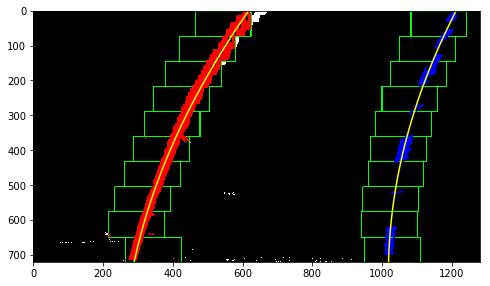

In [13]:
def sliding_window(warped, leftx_base, rightx_base, display=False):
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx, right_fitx, left_fit, right_fit = None, None, None, None
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate x and y values for plotting
    if display:
        if left_fitx is not None and right_fitx is not None:
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.figure(figsize=(8,6))
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        
    return left_fitx, right_fitx, left_fit, right_fit

left_fitx, right_fitx, left_fit, right_fit = sliding_window(binary_warped, leftx_base, rightx_base, display=True)

### Use detetcted lines for future frames

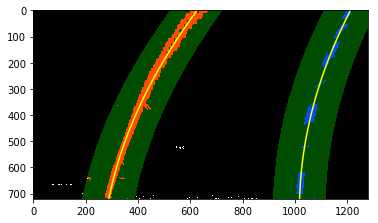

In [14]:
def detect_line_from_previous_frame(binary_warped, left_fit, right_fit, display=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Visualization
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    if display:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fitx, right_fitx, left_fit, right_fit

left_fitx, right_fitx, left_fit, right_fit = detect_line_from_previous_frame(binary_warped, left_fit, right_fit, display=True)


In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def radius_and_offset(warped, left_fitx, right_fitx):
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curve_rad, 'm', right_curve_rad, 'm')
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    # print("Radius of curvature: %.2f m" % average_curve_rad)

    # compute the offset from the center
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    center_offset_pixels = img.shape[1]/2 - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    # print(offset_string)
    return average_curve_rad, center_offset_mtrs
    
radius_and_offset(binary_warped, left_fitx, right_fitx)

(467.23968878616688, -0.071042151681193086)

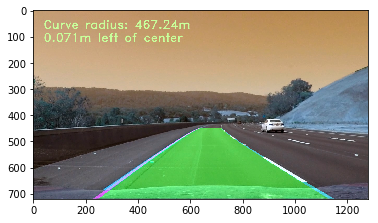

In [16]:
def overlay_text(original_img, average_curve_rad, center_offset_mtrs):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(average_curve_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_offset_mtrs > 0:
        direction = 'right'
    elif center_offset_mtrs < 0:
        direction = 'left'
    abs_center_dist = abs(center_offset_mtrs)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img


# Create an image to draw the lines on
def colorLane(img, binary_warped, left_fit, right_fit, display=False):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int_([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    average_curve_rad, center_offset_mtrs = radius_and_offset(binary_warped, left_fitx, right_fitx)
    result = overlay_text(result, average_curve_rad, center_offset_mtrs)
    if display:
        plt.imshow(result)
    return result


result = colorLane(img, binary_warped, left_fit, right_fit, display=True)

### Define a class to store data

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def check_fit(diffs):
        # check the difference in fit is within a threshold
        return (diffs[0] > 0.001 or \
            diffs[1] > 1.0 or \
            diffs[2] > 100.)
    
    def add_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (Line.check_fit(self.diffs)) and \
               len(self.current_fit) > 0:
                # bad fit, unless there are no fits in the current_fit
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [18]:
l_line = Line()
r_line = Line()
def pipeline(img):
    thresholded = threshold_image(img)
    binary_warped = warp(thresholded)
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        histogram, leftx_base, rightx_base = get_hist_and_xbase(binary_warped)   
        left_fitx, right_fitx, left_fit, right_fit = sliding_window(binary_warped, leftx_base, rightx_base)
    else:
        left_fitx, right_fitx, left_fit, right_fit = detect_line_from_previous_frame(binary_warped, l_line.best_fit, r_line.best_fit, display=False)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        # print(x_int_diff)
        if abs(750 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
    l_line.add_fit(left_fit)
    r_line.add_fit(right_fit)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        result = colorLane(img, binary_warped, l_line.best_fit, r_line.best_fit, display=False)
    else:
        result = img
    return result

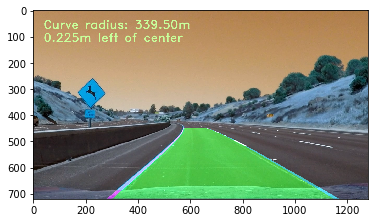

In [19]:
img = cv2.imread('test_images/test2.jpg')
result = pipeline(img)
plt.imshow(result)

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:22<00:00,  6.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 50s, sys: 45.7 s, total: 4min 36s
Wall time: 3min 23s
